# Air Quality

In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import r2_score

In [289]:
pd.set_option('display.max_columns', None)

## EDA

Data Set Information:

The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. Missing values are tagged with -200 value.
This dataset can be used exclusively for research purposes. Commercial purposes are fully excluded.


Read the dataset

In [200]:
df = pd.read_csv('data/raw/AirQualityUCI.csv', sep=';')

Lets glance on it 

In [201]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


### Clean df

We see that date and time is not in index, and there is a empty columns at the end of df. So we should to delete them 

In [202]:
df.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1, inplace=True)

Thats better

In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
dtypes: float64(8), object(7)
memory usage: 1.1+ MB


There are 9471 entry and 9357 raws in each column. Lets see if this empty rows is empty at every colunms

In [204]:
df[df.isnull().any(axis=1)]

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
9357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It is just empty raws and they can be deleted without harm to our df.

In [205]:
df.dropna(how='all', inplace=True)

In [206]:
df.tail()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
9352,04/04/2005,10.00.00,"3,1",1314.0,-200.0,"13,5",1101.0,472.0,539.0,190.0,1374.0,1729.0,"21,9","29,3","0,7568"
9353,04/04/2005,11.00.00,"2,4",1163.0,-200.0,"11,4",1027.0,353.0,604.0,179.0,1264.0,1269.0,"24,3","23,7","0,7119"
9354,04/04/2005,12.00.00,"2,4",1142.0,-200.0,"12,4",1063.0,293.0,603.0,175.0,1241.0,1092.0,"26,9","18,3","0,6406"
9355,04/04/2005,13.00.00,"2,1",1003.0,-200.0,"9,5",961.0,235.0,702.0,156.0,1041.0,770.0,"28,3","13,5","0,5139"
9356,04/04/2005,14.00.00,"2,2",1071.0,-200.0,"11,9",1047.0,265.0,654.0,168.0,1129.0,816.0,"28,5","13,1","0,5028"


Now we see, that we done with nan values. Lets take care about "-200" values

In [207]:
df.replace([-200, -200.0 , '-200', '-200,0', '-200.0'], np.nan, inplace=True)

We see there are no missed value in target feature. But before we deal with missing data we should do better index. Best way to do it is to merge date and time to datetime index and work with the df as timeseries

In [208]:
df['datetime'] = df['Date'] + ':' + df['Time']

In [209]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,datetime
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",10/03/2004:18.00.00
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",10/03/2004:19.00.00
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",10/03/2004:20.00.00
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",10/03/2004:21.00.00
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",10/03/2004:22.00.00


In [210]:
df['datetime'] = pd.to_datetime(df['datetime'], format="%d/%m/%Y:%H.%M.%S")

In [211]:
df.dtypes

Date                     object
Time                     object
CO(GT)                   object
PT08.S1(CO)             float64
NMHC(GT)                float64
C6H6(GT)                 object
PT08.S2(NMHC)           float64
NOx(GT)                 float64
PT08.S3(NOx)            float64
NO2(GT)                 float64
PT08.S4(NO2)            float64
PT08.S5(O3)             float64
T                        object
RH                       object
AH                       object
datetime         datetime64[ns]
dtype: object

In [212]:
df.set_index('datetime', inplace=True)

In [213]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
datetime,,,,,,,,,,,,,,,
2004-03-10 18:00:00,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578"
2004-03-10 19:00:00,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255"
2004-03-10 20:00:00,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502"
2004-03-10 21:00:00,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867"
2004-03-10 22:00:00,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888"


In [214]:
pd.date_range(start = df.index.min(), end = df.index.max() , freq='H').difference(df.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [215]:
df.index.nunique

<bound method IndexOpsMixin.nunique of DatetimeIndex(['2004-03-10 18:00:00', '2004-03-10 19:00:00',
               '2004-03-10 20:00:00', '2004-03-10 21:00:00',
               '2004-03-10 22:00:00', '2004-03-10 23:00:00',
               '2004-03-11 00:00:00', '2004-03-11 01:00:00',
               '2004-03-11 02:00:00', '2004-03-11 03:00:00',
               ...
               '2005-04-04 05:00:00', '2005-04-04 06:00:00',
               '2005-04-04 07:00:00', '2005-04-04 08:00:00',
               '2005-04-04 09:00:00', '2005-04-04 10:00:00',
               '2005-04-04 11:00:00', '2005-04-04 12:00:00',
               '2005-04-04 13:00:00', '2005-04-04 14:00:00'],
              dtype='datetime64[ns]', name='datetime', length=9357, freq=None)>

In [216]:
df.isna().sum()

Date                0
Time                0
CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64

In [154]:
c_366 = ['PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)',  'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

In [155]:
c_1700 = ['CO(GT)', 'NOx(GT)', 'NO2(GT)']

In [156]:
c_9000 = ['NMHC(GT)']

In [157]:
df[df['PT08.S1(CO)'].isna()]

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
datetime,,,,,,,,,,,,,,,
2004-04-01 14:00:00,01/04/2004,14.00.00,"1,7",NaN,222.0,NaN,NaN,99.0,NaN,72.0,NaN,NaN,NaN,NaN,NaN
2004-04-01 15:00:00,01/04/2004,15.00.00,"1,9",NaN,197.0,NaN,NaN,108.0,NaN,81.0,NaN,NaN,NaN,NaN,NaN
2004-04-01 16:00:00,01/04/2004,16.00.00,"2,3",NaN,319.0,NaN,NaN,131.0,NaN,93.0,NaN,NaN,NaN,NaN,NaN
2004-04-08 23:00:00,08/04/2004,23.00.00,2,NaN,137.0,NaN,NaN,129.0,NaN,106.0,NaN,NaN,NaN,NaN,NaN
2004-04-09 00:00:00,09/04/2004,00.00.00,"2,4",NaN,189.0,NaN,NaN,154.0,NaN,109.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-02-11 17:00:00,11/02/2005,17.00.00,"6,6",NaN,NaN,NaN,NaN,1227.0,NaN,326.0,NaN,NaN,NaN,NaN,NaN
2005-02-11 18:00:00,11/02/2005,18.00.00,"6,5",NaN,NaN,NaN,NaN,1061.0,NaN,284.0,NaN,NaN,NaN,NaN,NaN
2005-02-11 19:00:00,11/02/2005,19.00.00,"7,1",NaN,NaN,NaN,NaN,1075.0,NaN,289.0,NaN,NaN,NaN,NaN,NaN


One thing to do before I start experiment 1. I dont need anymore two columns - Date and Time. 

In [158]:
df.drop(['Date', 'Time'], axis=1, inplace=True)

And I think, I can delete feature with na values > 70% it hasnt got a lot of information, and Im not sure can I impute so many values

In [217]:
df.drop(c_9000, axis=1, inplace=True)

In [218]:
df['C6H6(GT)'] = df['C6H6(GT)'].str.replace(',','.').astype('float')
df['T'] = df['T'].str.replace(',','.').astype('float')
df['RH'] = df['RH'].str.replace(',','.').astype('float')
df['AH'] = df['AH'].str.replace(',','.').astype('float')
df['CO(GT)'] = df['CO(GT)'].str.replace(',','.').astype('float')

In [219]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
datetime,,,,,,,,,,,,,,
2004-03-10 18:00:00,10/03/2004,18.00.00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,10/03/2004,19.00.00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,10/03/2004,20.00.00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,10/03/2004,21.00.00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,10/03/2004,22.00.00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [220]:
df.describe()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,7674.000000,8991.000000,8991.000000,8991.000000,7718.000000,8991.000000,7715.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000
mean,2.152750,1099.833166,10.083105,939.153376,246.896735,835.493605,113.091251,1456.264598,1022.906128,18.317829,49.234201,1.025530
std,1.453252,217.080037,7.449820,266.831429,212.979168,256.817320,48.370108,346.206794,398.484288,8.832116,17.316892,0.403813
min,0.100000,647.000000,0.100000,383.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700
25%,1.100000,937.000000,4.400000,734.500000,98.000000,658.000000,78.000000,1227.000000,731.500000,11.800000,35.800000,0.736800
50%,1.800000,1063.000000,8.200000,909.000000,180.000000,806.000000,109.000000,1463.000000,963.000000,17.800000,49.600000,0.995400
75%,2.900000,1231.000000,14.000000,1116.000000,326.000000,969.500000,142.000000,1674.000000,1273.500000,24.400000,62.500000,1.313700
max,11.900000,2040.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


# Experiment 1 
## Interpolation or regression

As we saw before there is some groups of missing values. First froup counts 366 missing value in 9 features. They are all in one time period.

So i decided to do experiment what type of imputation will be better to deal with this data. For this purpose I choose feature PT08.S1(CO) with first missing value at date 2004-04-01 14:00:00 and the last one at 2005-03-11 11:00:00. 

As we see in the table below, there are raws when we able to use  only 3- 4 features thats why I think that interpolation will give a better results.

First of all for my expreriment I need sample of data without na values before and after missing data I want to impute. On this sample I will train my model, see the metrics, and choose best appropriate model ro fill na values in a target feature. 

In [221]:
df[df['PT08.S1(CO)'].isna()]

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
datetime,,,,,,,,,,,,,,
2004-04-01 14:00:00,01/04/2004,14.00.00,1.7,NaN,NaN,NaN,99.0,NaN,72.0,NaN,NaN,NaN,NaN,NaN
2004-04-01 15:00:00,01/04/2004,15.00.00,1.9,NaN,NaN,NaN,108.0,NaN,81.0,NaN,NaN,NaN,NaN,NaN
2004-04-01 16:00:00,01/04/2004,16.00.00,2.3,NaN,NaN,NaN,131.0,NaN,93.0,NaN,NaN,NaN,NaN,NaN
2004-04-08 23:00:00,08/04/2004,23.00.00,2.0,NaN,NaN,NaN,129.0,NaN,106.0,NaN,NaN,NaN,NaN,NaN
2004-04-09 00:00:00,09/04/2004,00.00.00,2.4,NaN,NaN,NaN,154.0,NaN,109.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-02-11 17:00:00,11/02/2005,17.00.00,6.6,NaN,NaN,NaN,1227.0,NaN,326.0,NaN,NaN,NaN,NaN,NaN
2005-02-11 18:00:00,11/02/2005,18.00.00,6.5,NaN,NaN,NaN,1061.0,NaN,284.0,NaN,NaN,NaN,NaN,NaN
2005-02-11 19:00:00,11/02/2005,19.00.00,7.1,NaN,NaN,NaN,1075.0,NaN,289.0,NaN,NaN,NaN,NaN,NaN


### Statistics for target feature PT08.S1(CO) 

In [222]:
df['PT08.S1(CO)'].describe()

count    8991.000000
mean     1099.833166
std       217.080037
min       647.000000
25%       937.000000
50%      1063.000000
75%      1231.000000
max      2040.000000
Name: PT08.S1(CO), dtype: float64

Mean and median here are pretty close. But 3 qurtile are pretty far form the maximum. So I think there are outliers. Lets see plot. IQR is close to std.

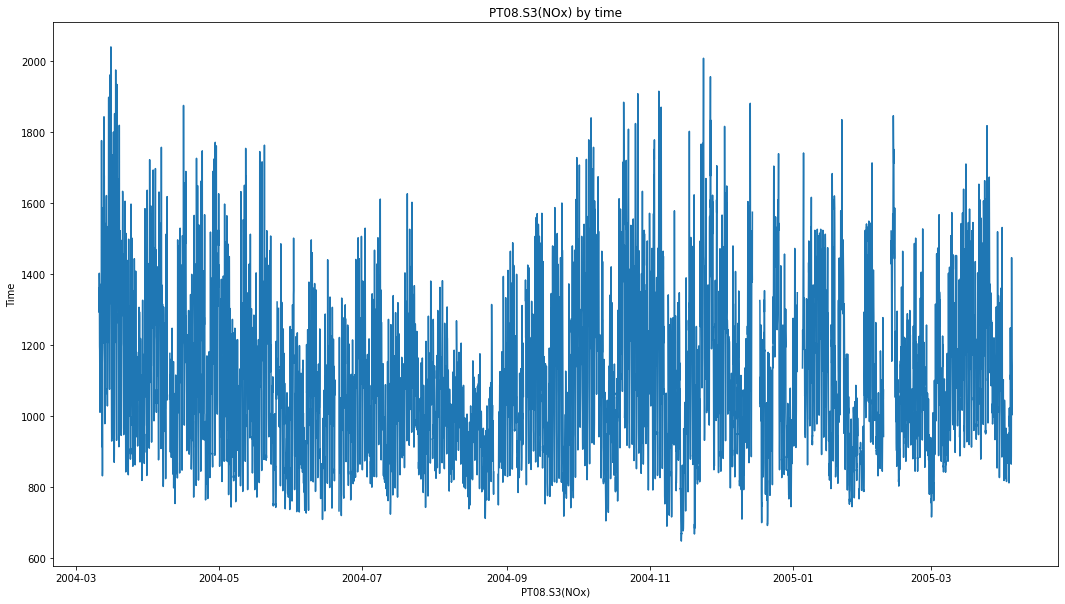

In [223]:
plt.figure(figsize=(18,10))
plt.plot(df.index,df['PT08.S1(CO)'])
plt.title('PT08.S3(NOx) by time')
plt.xlabel('PT08.S3(NOx)')
plt.ylabel('Time')
plt.show()

So some anomaly happends in this period, but I dont have enought data to make assumtions about what happends there.

**Histogram**

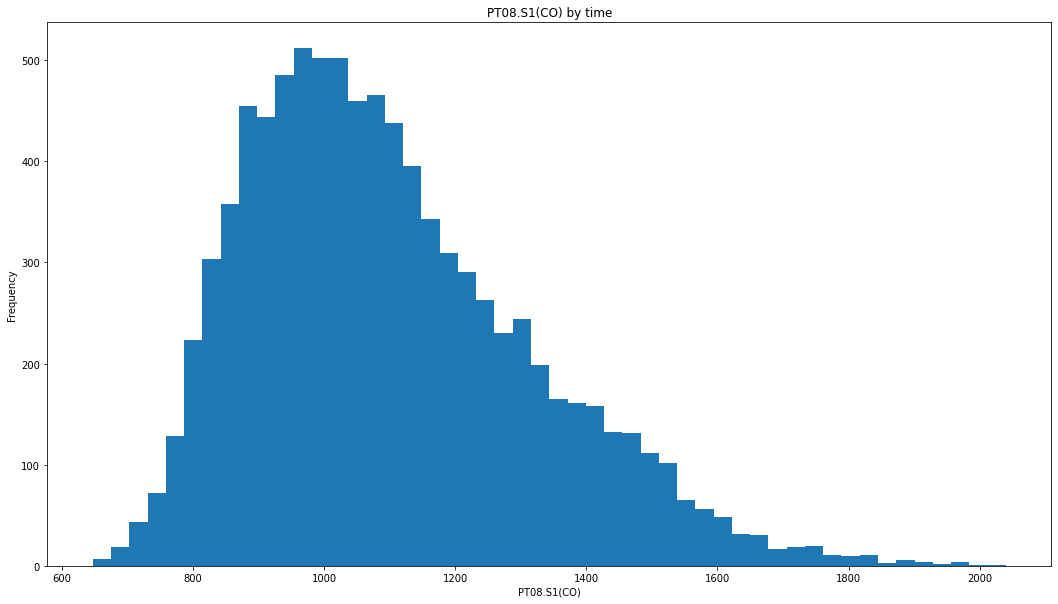

In [224]:
plt.figure(figsize=(18,10))
plt.hist(df['PT08.S1(CO)'], bins = 50)
plt.title('PT08.S1(CO) by time')
plt.xlabel('PT08.S1(CO)')
plt.ylabel('Frequency')
plt.show()

Its like a normal distribution with big skew to the hight values.

N0 = there is no trend

N1 = maybe there is trend

Check my hypotesis by taken first diff and see on the plot 

In [225]:
df['PT08.S1(CO)_dif1'] = df['PT08.S1(CO)'].diff()

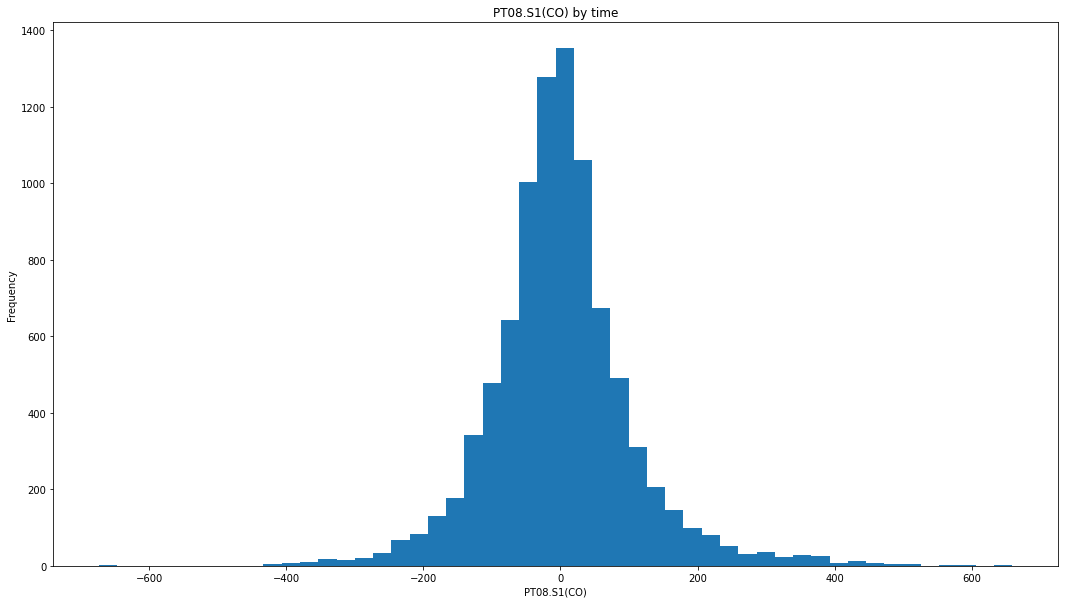

In [226]:
plt.figure(figsize=(18,10))
plt.hist(df['PT08.S1(CO)_dif1'], bins = 50)
plt.title('PT08.S1(CO) by time')
plt.xlabel('PT08.S1(CO)')
plt.ylabel('Frequency')
plt.show()

**Conclusion**

We see here that it is much more like normal distribution so I will reject N0 and will say there is trend in feature PT08.S1(CO) 

### Isolation Forest

before isolation Forest needed to remove Na values. We need them letter, so I will make another df

In [230]:
dfn = df.copy()

In [231]:
dfn = dfn.drop(c_1700, axis=1)

In [232]:
dfn = dfn.dropna(subset=c_366, axis=0, how='all')

In [233]:
dfn.isna().sum()

Date                 0
Time                 0
PT08.S1(CO)          0
C6H6(GT)             0
PT08.S2(NMHC)        0
PT08.S3(NOx)         0
PT08.S4(NO2)         0
PT08.S5(O3)          0
T                    0
RH                   0
AH                   0
PT08.S1(CO)_dif1    17
dtype: int64

So now we see 1: there is no rows with only one na, 2: we have df without na for experiment 

In [234]:
dfn.head()

,Date,Time,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,PT08.S1(CO)_dif1
datetime,,,,,,,,,,,,
2004-03-10 18:00:00,10/03/2004,18.00.00,1360.0,11.9,1046.0,1056.0,1692.0,1268.0,13.6,48.9,0.7578,NaN
2004-03-10 19:00:00,10/03/2004,19.00.00,1292.0,9.4,955.0,1174.0,1559.0,972.0,13.3,47.7,0.7255,-68.0
2004-03-10 20:00:00,10/03/2004,20.00.00,1402.0,9.0,939.0,1140.0,1555.0,1074.0,11.9,54.0,0.7502,110.0
2004-03-10 21:00:00,10/03/2004,21.00.00,1376.0,9.2,948.0,1092.0,1584.0,1203.0,11.0,60.0,0.7867,-26.0
2004-03-10 22:00:00,10/03/2004,22.00.00,1272.0,6.5,836.0,1205.0,1490.0,1110.0,11.2,59.6,0.7888,-104.0


There are some outluiers in every feature twice bigger that 3 quartile, and mean is very close to median

In [235]:
clf = IsolationForest(random_state=42, n_estimators=100)

In [236]:
dfn.loc[:,'PT08.S3(NOx) Out'] = clf.fit_predict(dfn['PT08.S1(CO)'].values.reshape(-1, 1))

In [237]:
dfn[dfn['PT08.S3(NOx) Out'] == -1]

,Date,Time,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,PT08.S1(CO)_dif1,PT08.S3(NOx) Out
datetime,,,,,,,,,,,,,
2004-03-10 18:00:00,10/03/2004,18.00.00,1360.0,11.9,1046.0,1056.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,-1
2004-03-10 20:00:00,10/03/2004,20.00.00,1402.0,9.0,939.0,1140.0,1555.0,1074.0,11.9,54.0,0.7502,110.0,-1
2004-03-10 21:00:00,10/03/2004,21.00.00,1376.0,9.2,948.0,1092.0,1584.0,1203.0,11.0,60.0,0.7867,-26.0,-1
2004-03-11 09:00:00,11/03/2004,09.00.00,1351.0,9.5,960.0,1079.0,1583.0,1028.0,10.5,60.6,0.7691,18.0,-1
2004-03-11 14:00:00,11/03/2004,14.00.00,1371.0,11.5,1034.0,983.0,1730.0,1037.0,8.0,81.1,0.8736,85.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-02 03:00:00,02/04/2005,03.00.00,820.0,1.4,536.0,1137.0,777.0,374.0,11.9,35.6,0.4945,-15.0,-1
2005-04-02 04:00:00,02/04/2005,04.00.00,815.0,0.9,488.0,1223.0,742.0,326.0,11.2,38.3,0.5099,-5.0,-1
2005-04-03 05:00:00,03/04/2005,05.00.00,811.0,1.0,494.0,1118.0,872.0,470.0,9.6,51.0,0.6082,-39.0,-1


**Conclusion**

Isolation Forest results is not so good, we see in the table above, then it shows a lot of outliners and a lot of them lying in IQR, its not a goot result, so I will not use it 

In [238]:
dfn.drop('PT08.S3(NOx) Out', axis=1, inplace=True)

### Scatter Plot 

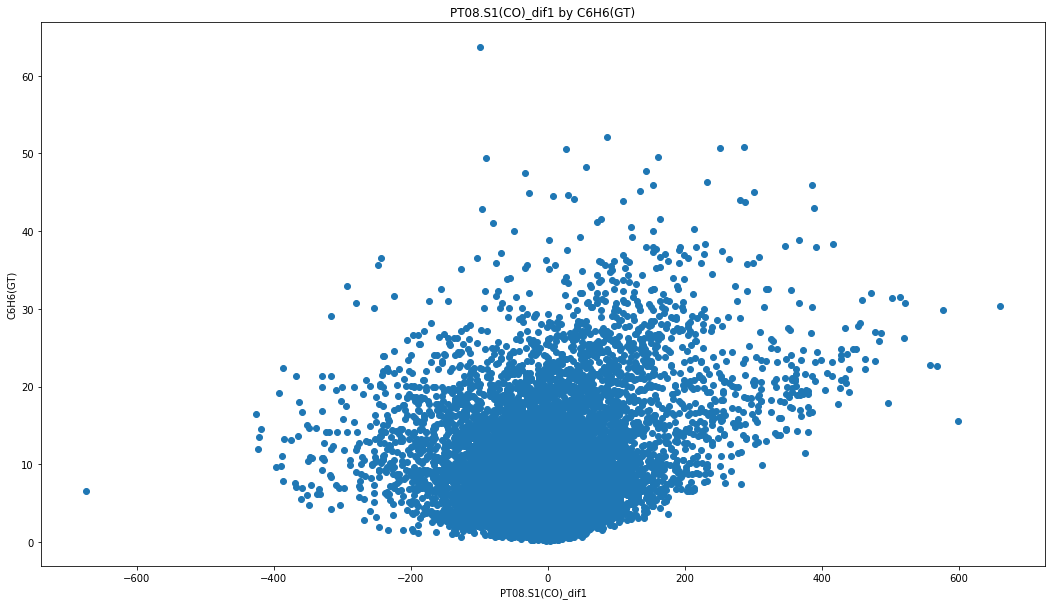

In [239]:
plt.figure(figsize=(18,10))
plt.scatter(dfn['PT08.S1(CO)_dif1'], dfn['C6H6(GT)'])
plt.title('PT08.S1(CO)_dif1 by C6H6(GT)')
plt.xlabel('PT08.S1(CO)_dif1')
plt.ylabel('C6H6(GT)')
plt.show()

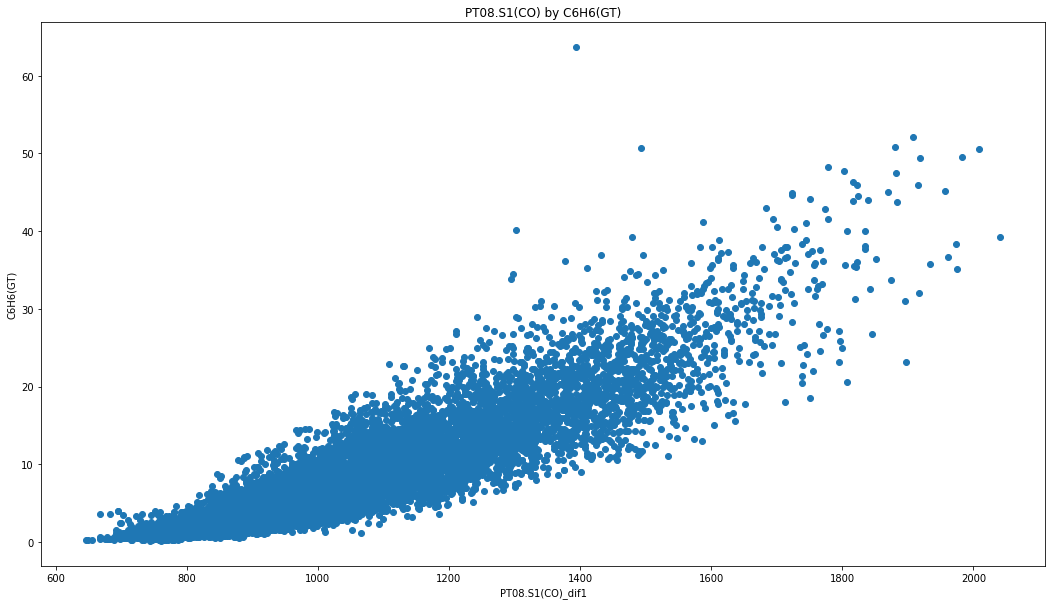

In [240]:
plt.figure(figsize=(18,10))
plt.scatter(dfn['PT08.S1(CO)'], dfn['C6H6(GT)'])
plt.title('PT08.S1(CO) by C6H6(GT)')
plt.xlabel('PT08.S1(CO)_dif1')
plt.ylabel('C6H6(GT)')
plt.show()

We can see strong correlation on the plot and I  suppose this is becouse of trend 


N0 - there is no correlation

N1 - there is correlation

I will try to count Person correlation coeficient 

In [241]:
stats.pearsonr(dfn['PT08.S1(CO)'], dfn['C6H6(GT)'])

(0.8837950766080699, 0.0)

So we can reject null hypotesis and say than there is a strong correlation beetwen those faetures.

What I want to do is find out whether the change in PT08.S1(CO) earlier in time can predict the change in C6H6(GT) later in time . 

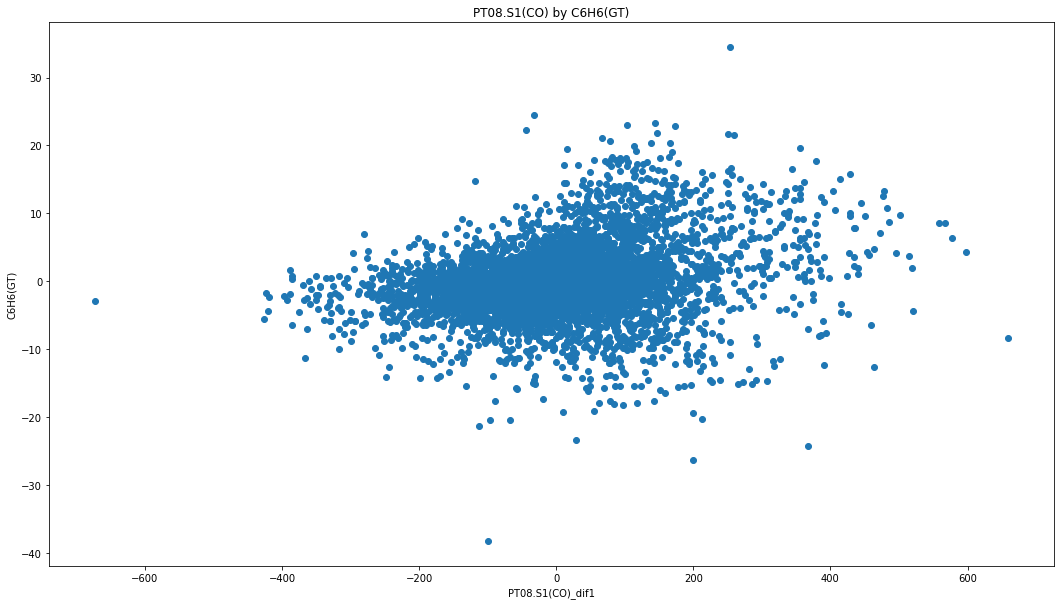

In [242]:
plt.figure(figsize=(18,10))
plt.scatter(dfn['PT08.S1(CO)_dif1'].shift(1), dfn['C6H6(GT)'].diff())
plt.title('PT08.S1(CO) by C6H6(GT)')
plt.xlabel('PT08.S1(CO)_dif1')
plt.ylabel('C6H6(GT)')
plt.show()

We can see here heteroscedasticity so i assume that  interconnection here is not linear 

In [243]:
dnf_2 = dfn.dropna(how='any', axis=0)

In [244]:
stats.pearsonr(dnf_2['PT08.S1(CO)_dif1'].shift(1)[2:], dnf_2['C6H6(GT)'].diff()[2:])

(0.266183808839643, 2.2733300864519927e-145)

**Conclusion**

We can say that we can predict values of C6H6(GT) by values of PT08.S1(CO)_dif1 one hour before. 

So Ill make another feature from PT08.S1(CO)

In [245]:
dfn['PT08.S1(CO)_dif1_lag1'] = dfn['PT08.S1(CO)_dif1'].shift(1)

### Seasonality

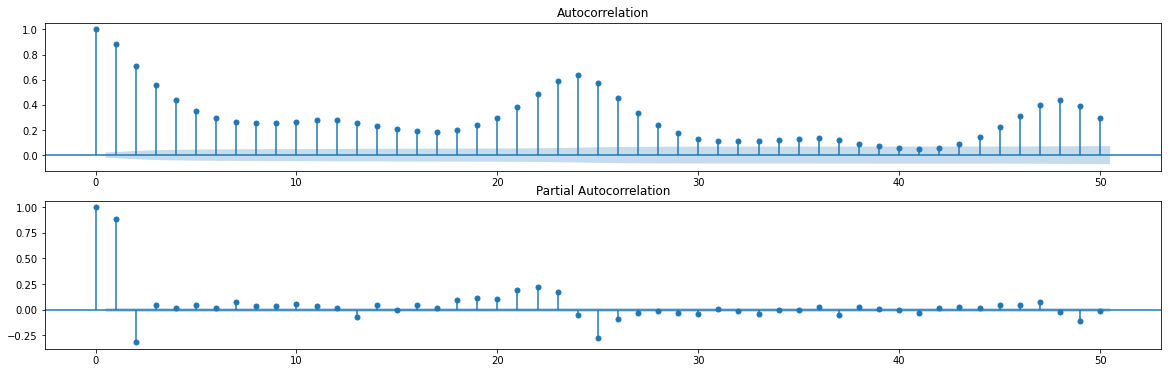

In [246]:
fig, ax = plt.subplots(2, figsize=(20,6))
ax[0] = plot_acf(dfn['PT08.S1(CO)'], ax=ax[0], lags=50)
ax[1] = plot_pacf(dfn['PT08.S1(CO)'], ax=ax[1], lags=50)
plt.show()

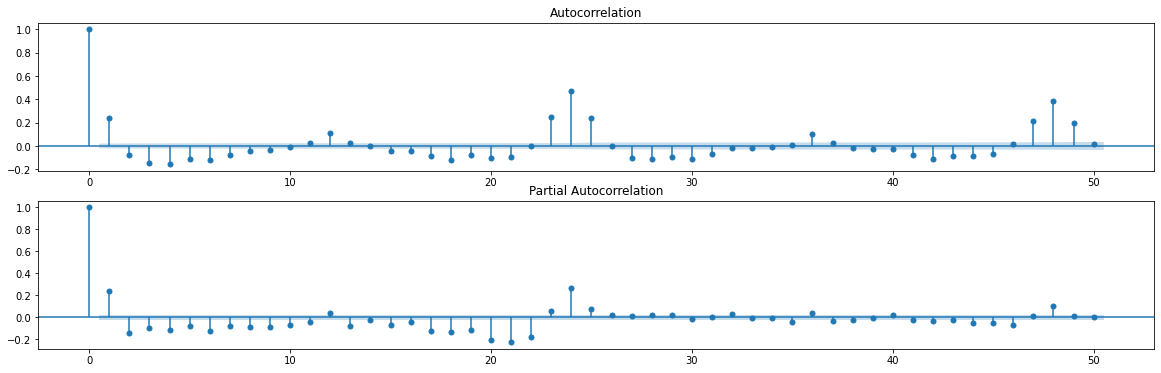

In [247]:
fig, ax = plt.subplots(2, figsize=(20,6))
ax[0] = plot_acf(dnf_2['PT08.S1(CO)_dif1'], ax=ax[0], lags=50)
ax[1] = plot_pacf(dnf_2['PT08.S1(CO)_dif1'], ax=ax[1], lags=50)
plt.show()

We see strong correlation with second hour and 24 hours cycle. Our data is not stationar. It will be hard to make linear model to fit the data. 

But plot plot of the first difference shows as that data without trend is stationar. And there is a 24 hours cycle.

I want to make SARIMAX reseach, but later.

Lets go back to Experiment 1.

The goal of experiment - find the model which will be the best to impute values in original dataset. 

I will make new columns for each tested method to compare the value later.

Ill make coyp of df to count it impute score and randomly add missing values

In [274]:
df_exp_1 = df.copy()

In [275]:
#df_exp_1.to_csv('data/interim/df_exp_1.csv')

In [276]:
df_exp_1.dropna(inplace=True, how='any') 

In [277]:
df_exp_1.describe()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,PT08.S1(CO)_dif1
count,6928.000000,6928.000000,6928.000000,6928.000000,6928.000000,6928.000000,6928.000000,6928.000000,6928.000000,6928.000000,6928.000000,6928.000000,6928.000000
mean,2.181741,1119.737009,10.553637,958.500577,250.646940,816.904446,113.860566,1452.766166,1057.381495,17.757535,48.880788,0.985685,1.920035
std,1.440977,218.678430,7.468155,264.094798,208.675099,251.857045,47.471437,353.445092,406.262040,8.845056,17.436367,0.401158,107.181532
min,0.100000,647.000000,0.200000,390.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700,-673.000000
25%,1.100000,956.000000,4.900000,760.000000,103.000000,642.000000,79.000000,1207.000000,759.750000,11.200000,35.300000,0.694025,-54.000000
50%,1.900000,1085.000000,8.800000,931.000000,186.000000,786.000000,110.000000,1458.000000,1006.000000,16.800000,49.200000,0.954350,-1.000000
75%,2.900000,1253.250000,14.600000,1135.000000,334.000000,947.000000,142.000000,1683.000000,1322.000000,23.700000,62.200000,1.251950,51.000000
max,11.900000,2040.000000,63.700000,2214.000000,1479.000000,2683.000000,333.000000,2775.000000,2523.000000,44.600000,88.700000,2.180600,659.000000


In [280]:
df_exp_1 =df_exp_1.assign(reference = df_exp_1['PT08.S1(CO)'])

In [281]:
add_miss_rat = 0.2
vals_to_nan = df_exp_1['PT08.S1(CO)'].dropna().sample(frac=add_miss_rat).index
df_exp_1.loc[vals_to_nan, 'PT08.S1(CO)'] = np.NaN

In [282]:
df_exp_1.isna().sum()

Date                   0
Time                   0
CO(GT)                 0
PT08.S1(CO)         1386
C6H6(GT)               0
PT08.S2(NMHC)          0
NOx(GT)                0
PT08.S3(NOx)           0
NO2(GT)                0
PT08.S4(NO2)           0
PT08.S5(O3)            0
T                      0
RH                     0
AH                     0
PT08.S1(CO)_dif1       0
reference              0
dtype: int64

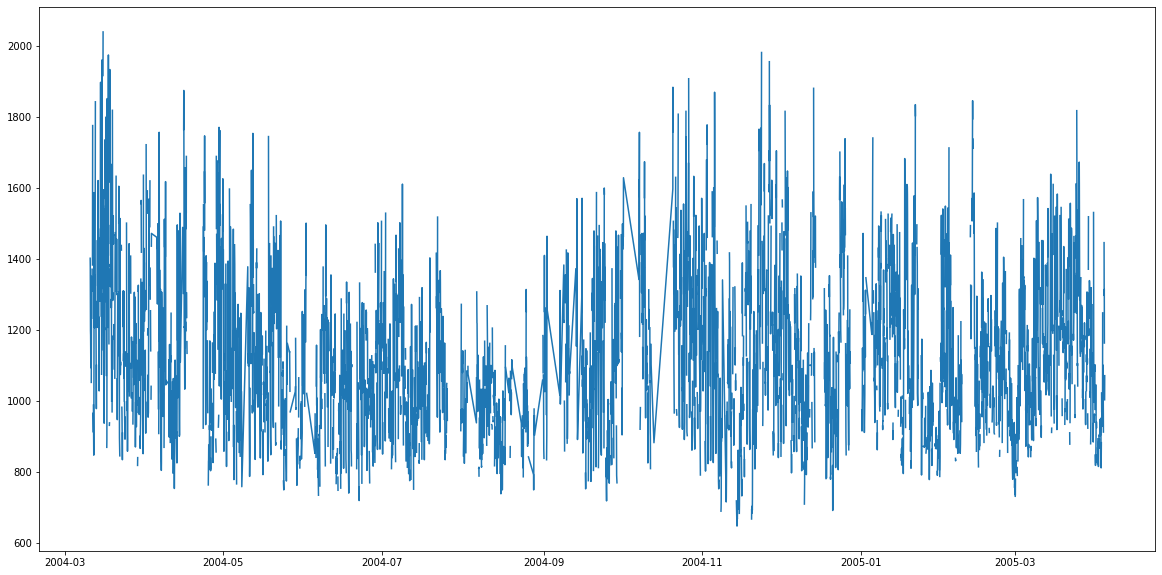

In [284]:
plt.figure(figsize=(20,10))
plt.plot(df_exp_1['PT08.S1(CO)'])
plt.show()

**Try to inmupte using the rolling average**

In [286]:
df_exp_1 = df_exp_1.assign(RollingMean = df_exp_1['PT08.S1(CO)'].fillna(df_exp_1['PT08.S1(CO)'].rolling(24, min_periods=1, ).mean()))

In [287]:
df_exp_1 = df_exp_1.assign(RollingMean = df_exp_1['PT08.S1(CO)'].fillna(df_exp_1['PT08.S1(CO)'].rolling(24, min_periods=1, ).median()))

**Imputing using interpolation with different methods**

In [285]:
df_exp_1 = df_exp_1.assign(InterpolateLinear = df_exp_1['PT08.S1(CO)'].interpolate(method='linear'))
df_exp_1 = df_exp_1.assign(InterpolateTime = df_exp_1['PT08.S1(CO)'].interpolate(method='time'))
df_exp_1 = df_exp_1.assign(InterpolateQuadratic = df_exp_1['PT08.S1(CO)'].interpolate(method='quadratic'))
df_exp_1 = df_exp_1.assign(InterpolateCubic = df_exp_1['PT08.S1(CO)'].interpolate(method='cubic'))
df_exp_1 = df_exp_1.assign(InterpolateSlinear = df_exp_1['PT08.S1(CO)'].interpolate(method='slinear'))
df_exp_1 = df_exp_1.assign(InterpolateAkima = df_exp_1['PT08.S1(CO)'].interpolate(method='akima'))
df_exp_1 = df_exp_1.assign(InterpolatePoly3 = df_exp_1['PT08.S1(CO)'].interpolate(method='polynomial', order=3))
df_exp_1 = df_exp_1.assign(InterpolatePoly5 = df_exp_1['PT08.S1(CO)'].interpolate(method='polynomial', order=5))
df_exp_1 = df_exp_1.assign(InterpolatePoly7 = df_exp_1['PT08.S1(CO)'].interpolate(method='polynomial', order=7))

df_exp_1 = df_exp_1.assign(InterpolateSpline3 = df_exp_1['PT08.S1(CO)'].interpolate(method='spline', order=3))
df_exp_1 = df_exp_1.assign(InterpolateSpline4 = df_exp_1['PT08.S1(CO)'].interpolate(method='spline', order=4))
df_exp_1 = df_exp_1.assign(InterpolateSpline5 = df_exp_1['PT08.S1(CO)'].interpolate(method='spline', order=5))

In [292]:
list(df_exp_1)[16:]

['InterpolateLinear',
 'InterpolateTime',
 'InterpolateQuadratic',
 'InterpolateCubic',
 'InterpolateSlinear',
 'InterpolateAkima',
 'InterpolatePoly3',
 'InterpolatePoly5',
 'InterpolatePoly7',
 'InterpolateSpline3',
 'InterpolateSpline4',
 'InterpolateSpline5',
 'RollingMean']

**Scoring the results and see which is better**

In [295]:
results = [(method, r2_score(df_exp_1.reference[1:], df_exp_1[method][1:])) for method in list(df_exp_1)[16:]]
results_df = pd.DataFrame(np.array(results), columns=['Method', 'R_squared'])
results_df.sort_values(by='R_squared', ascending=False)

,Method,R_squared
5,InterpolateAkima,0.9773263508889237
2,InterpolateQuadratic,0.9769309661465905
9,InterpolateSpline3,0.9762519555264851
3,InterpolateCubic,0.9762322092489834
6,InterpolatePoly3,0.9762322092489834
1,InterpolateTime,0.9741966122833584
4,InterpolateSlinear,0.9741966122833584
0,InterpolateLinear,0.9735634976350287
10,InterpolateSpline4,0.9643961522176638
7,InterpolatePoly5,0.9600806307819167
